# MASE Download

In [ ]:
# Check the current python version (It should be using Python 3.11) and update pip to the latest version.
!python3 --version
!python -m pip install --user --upgrade pip

import sys
print(sys.version)

Python 3.11.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to the file in Google Drive
config_file_path = '/content/drive/My Drive/auth_config.txt'

# Read the token and shortcode
auth_config = {}
with open(config_file_path, 'r') as file:
    for line in file:
        key, value = line.strip().split('=')
        auth_config[key] = value

# Extract token and shortcode
git_token = auth_config.get('token')
short_code = auth_config.get('shortcode')

Mounted at /content/drive


In [ ]:
!git clone https://{git_token}@github.com/DeepWok/mase.git


Cloning into 'mase'...
remote: Enumerating objects: 26658, done.
remote: Counting objects: 100% (3703/3703), done.
remote: Compressing objects: 100% (553/553), done.
remote: Total 26658 (delta 3359), reused 3167 (delta 3147), pack-reused 22955 (from 3)
Receiving objects: 100% (26658/26658), 114.68 MiB | 7.49 MiB/s, done.
Resolving deltas: 100% (17041/17041), done.


In [ ]:
%%bash
# Check if the branch exists. Branch exists, so checkout to that branch otherwise create a new one.
cd mase
# if git show-ref --quiet --verify "refs/heads/lab1_${short_code}"; then
#     # Branch exists, so checkout to that branch
#     git checkout lab1_${short_code}
# else
#     # Branch doesn't exist, so create it
#     git branch lab1_{short_code} git checkout lab1_
# {short_code}
# fi


In [ ]:
%%bash
cd mase
python -m pip install -e . -vvv

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
%cd ./mase/src/

/content/mase/src


# Lab 1.1
In Tutorial 3, you quantized every Linear layer in the model to the provided configuration. Now, explore a range of fixed point widths from 4 to 32.

Plot a figure where the x-axis is the fixed point width and the y-axis is the highest achieved accuracy on the IMDb dataset, following the procedure in Tutorial 3.

Plot separate curves for PTQ and QAT at each precision to show the effect of post-quantization finetuning.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from chop import MaseGraph
from chop.tools import get_tokenized_dataset, get_trainer
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

path = '/content/drive/My Drive/ADLS/Models'
mg = MaseGraph.from_checkpoint(path + r"/tutorial_2_lora")

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loaded metadat

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
"""
Fixed-Point Quantization: Instead of using floating-point numbers computations are performed using fixed-point representations (e.g., 4-bit, 8-bit, 16-bit, etc.).
Post-Training Quantization (PTQ): Applies quantization after training without fine-tuning.
Quantization-Aware Training (QAT): Fine-tunes a quantized model to recover accuracy lost during quantization.
The code tests different bit widths to find the best trade-off between accuracy and quantization efficiency.
"""

fixed_point_widths = range(4, 33, 4)

# To track the best model
best_accuracy = 0
best_model = None
best_config = None
best_type = None  # Either "PTQ" or "QAT"

ptq_accuracies = []  # List to store PTQ accuracies
qat_accuracies = []  # List to store QAT accuracies

for width in fixed_point_widths:
  print(f"Fixed-Point Width: {width}")
  # Define the quantization configuration for the current width
  quantization_config = {
    "by": "type",
    "default": {"config": {"name": None}},
    "linear": {
        "config": {
            # Increasing data_in_width -> more integer bits allowing for larger numerical values.
            # Keeping data_in_frac_width fixed -> consistent fractional precision.
            "name": "integer", # Integer based
            "data_in_width": width, # Total bit width
            "data_in_frac_width": 4, # Fractional part width
            "weight_width": width,
            "weight_frac_width": 4,
            "bias_width": width,
            "bias_frac_width": 4,
        }
    },
  }

  # Apply PTQ
  mg_ptq, _ = passes.quantize_transform_pass(
      mg,
      pass_args=quantization_config,
  )
  ptq_accuracy = trainer.evaluate()["eval_accuracy"]  # Evaluate accuracy for PTQ
  ptq_accuracies.append(ptq_accuracy)

  # Check if PTQ is the best model so far
  if ptq_accuracy > best_accuracy:
      best_accuracy = ptq_accuracy
      best_model = mg_ptq
      best_config = quantization_config
      best_type = "PTQ"

  # Apply QAT
  trainer.train()  # Fine-tune the quantized model (QAT)
  qat_accuracy = trainer.evaluate()["eval_accuracy"]  # Evaluate accuracy for QAT
  qat_accuracies.append(qat_accuracy)

  # Check if QAT is the best model so far
  if qat_accuracy > best_accuracy:
      best_accuracy = qat_accuracy
      best_model = mg_ptq
      best_config = quantization_config
      best_type = "QAT"


Fixed-Point Width: 4


Step,Training Loss
500,0.633300
1000,0.565200
1500,0.522400
2000,0.485900
2500,0.490200
3000,0.484600


Fixed-Point Width: 8


Step,Training Loss
500,0.482000
1000,0.479700
1500,0.474000
2000,0.454000
2500,0.459400
3000,0.463600


Fixed-Point Width: 12


Step,Training Loss
500,0.463700
1000,0.457700
1500,0.462600
2000,0.434800
2500,0.444500
3000,0.452900


Fixed-Point Width: 16


Step,Training Loss
500,0.455400
1000,0.444700
1500,0.450600
2000,0.434400
2500,0.438800
3000,0.447200


Fixed-Point Width: 20


Step,Training Loss
500,0.447400
1000,0.438700
1500,0.453200
2000,0.426600
2500,0.430600
3000,0.436900


Fixed-Point Width: 24


Step,Training Loss
500,0.443200
1000,0.429500
1500,0.442600
2000,0.426900
2500,0.424300
3000,0.432900


Fixed-Point Width: 28


Step,Training Loss
500,0.428800
1000,0.421700
1500,0.445400
2000,0.416800
2500,0.421000
3000,0.432300


Fixed-Point Width: 32


Step,Training Loss
500,0.424600
1000,0.428000
1500,0.437000
2000,0.414200
2500,0.421300
3000,0.426500


In [ ]:
print(ptq_accuracies) #0.78556
print(qat_accuracies) # 0.80016

[0.51056, 0.78556, 0.80016, 0.80704, 0.81112, 0.81264, 0.81364, 0.81624]
[0.78556, 0.80016, 0.80704, 0.81112, 0.81264, 0.81364, 0.81624, 0.81968]


In [ ]:
# # Export the best model
# print(f"Best Model: {best_type} with Fixed-Point Width {best_config['linear']['config']['data_in_width']}")
# print(f"Accuracy: {best_accuracy}")
# best_model.export(path+r"\lab_1_1_best_model")

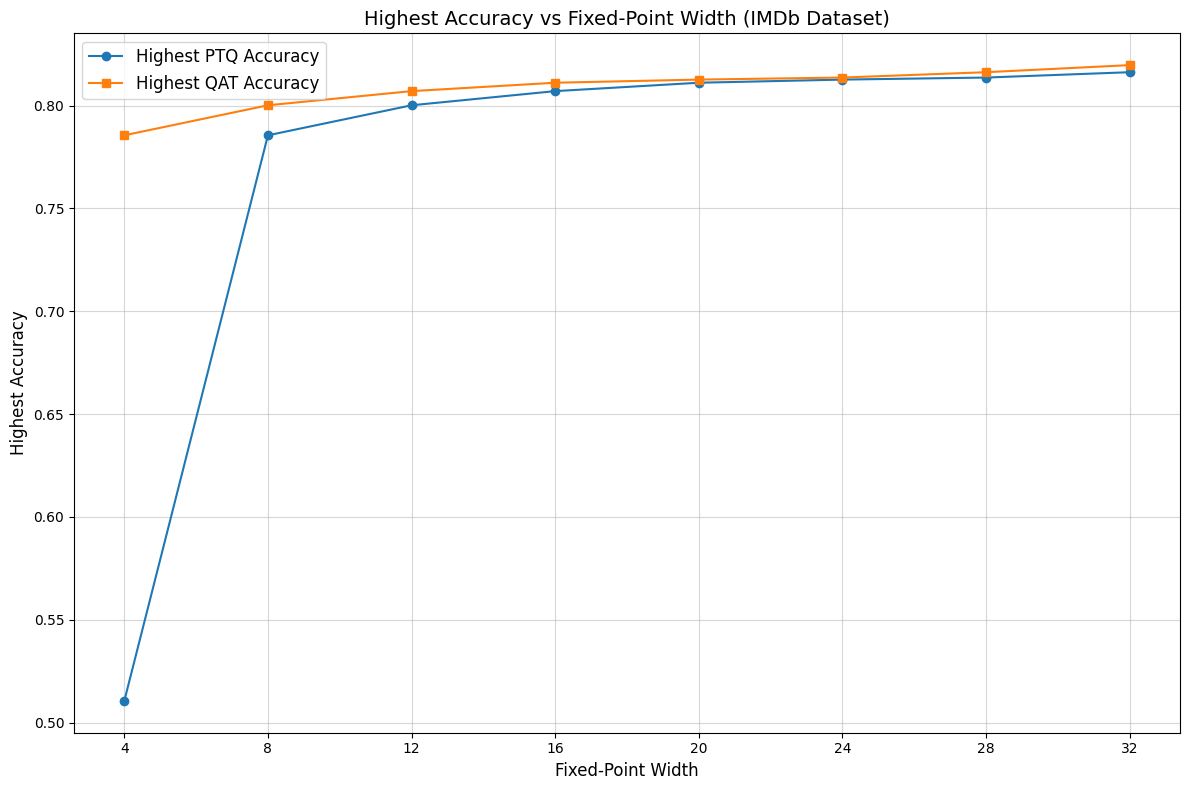

In [ ]:
import matplotlib.pyplot as plt
# Calculate the highest achieved accuracy so far for each width
highest_ptq_accuracies = []
highest_qat_accuracies = []

current_highest_ptq = 0
current_highest_qat = 0

for ptq_acc, qat_acc in zip(ptq_accuracies, qat_accuracies):
    current_highest_ptq = max(current_highest_ptq, ptq_acc)
    current_highest_qat = max(current_highest_qat, qat_acc)
    highest_ptq_accuracies.append(current_highest_ptq)
    highest_qat_accuracies.append(current_highest_qat)

# Plot the highest accuracy for PTQ and QAT
plt.figure(figsize=(12, 8))
plt.plot(fixed_point_widths, highest_ptq_accuracies, marker='o', label='Highest PTQ Accuracy')
plt.plot(fixed_point_widths, highest_qat_accuracies, marker='s', label='Highest QAT Accuracy')

plt.title("Highest Accuracy vs Fixed-Point Width (IMDb Dataset)", fontsize=14)
plt.xlabel("Fixed-Point Width", fontsize=12)
plt.ylabel("Highest Accuracy", fontsize=12)
plt.xticks(fixed_point_widths)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()


# Lab 1.2
Take your best obtained model from Task 1 and rerun the pruning procedure, this time varying the sparsity from 0.1 to 0.9.

Plot a figure where the x-axis is the sparsity and the y-axis is the highest achieved accuracy on the IMDb dataset, following the procedure in Tutorial 4.

Plot separate curves for Random and L1-Norm methods to evaluate the effect of different pruning strategies.

In [ ]:
import copy
sparsity_values = np.arange(0.1, 1, 0.1)  # Sparsity values from 0.1 to 0.9

methods = ['random', 'l1-norm']  # Pruning methods
accuracies = {method: [] for method in methods}  # Store accuracies for each method


for sparsity in sparsity_values:
    pruning_config = {
        "weight": {
            "sparsity": sparsity,
            "method": 'random',
            "scope": "local", # pruning is applied at a local level layer-wise rather than globally across the entire model
        },
        "activation": {
            "sparsity": sparsity,
            "method": 'random',
            "scope": "local",
        },
    }
    temp_model = copy.deepcopy(best_model.model)
    # If this is not added then I get an error for tensors being on cpu and cuda.
    mg = MaseGraph(
      temp_model.cpu(),
      hf_input_names=[
      "input_ids",
      "attention_mask",
      "labels",
      ],
  )

    mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)

    trainer = get_trainer(
        model=mg.model.cpu(),
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()  # Fine-tuning after pruning
    eval_results = trainer.evaluate()
    accuracy = eval_results['eval_accuracy']
    accuracies['random'].append(accuracy)
    print(f"Sparsity: {sparsity}, Method: {'random'}, Accuracy: {accuracy}")

print(accuracies)

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Train

Step,Training Loss
500,0.626300
1000,0.518800
1500,0.496600
2000,0.481400
2500,0.472700
3000,0.470200


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.1, Method: random, Accuracy: 0.79172


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.530200
1000,0.497700
1500,0.489500
2000,0.471300
2500,0.462200
3000,0.469700


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.2, Method: random, Accuracy: 0.79812


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.537500
1000,0.508700
1500,0.499800
2000,0.488500
2500,0.485900
3000,0.486900


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.30000000000000004, Method: random, Accuracy: 0.7868


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.643800
1000,0.590700
1500,0.556800
2000,0.535800
2500,0.526200
3000,0.525300


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.4, Method: random, Accuracy: 0.76116


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.692100
1000,0.685700
1500,0.681000
2000,0.676900
2500,0.672600
3000,0.668800


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.5, Method: random, Accuracy: 0.63212


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.695200
1000,0.692300
1500,0.691900
2000,0.693100
2500,0.692400
3000,0.693900


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.6, Method: random, Accuracy: 0.51232


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694300
1000,0.692900
1500,0.693400
2000,0.693100
2500,0.693200
3000,0.693300


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.7000000000000001, Method: random, Accuracy: 0.5014


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693500
1000,0.693100
1500,0.693200
2000,0.693100
2500,0.693300
3000,0.693300


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.8, Method: random, Accuracy: 0.50208


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693200
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693200


Sparsity: 0.9, Method: random, Accuracy: 0.50072
{'random': [0.79172, 0.79812, 0.7868, 0.76116, 0.63212, 0.51232, 0.5014, 0.50208, 0.50072], 'l1-norm': []}


In [ ]:
import copy
sparsity_values = np.arange(0.1, 1, 0.1)  # Sparsity values from 0.1 to 0.9

for sparsity in sparsity_values:
    pruning_config = {
        "weight": {
            "sparsity": sparsity,
            "method": "l1-norm", # Removes weights with the smallest absolute values which contribute less to the output
            "scope": "local",
        },
        "activation": {
            "sparsity": sparsity,
            "method": "l1-norm",
            "scope": "local",
        },
    }
    temp_model = copy.deepcopy(best_model.model)
    # If this is not added then I get an error for tensors being on cpu and cuda.
    mg = MaseGraph(
      temp_model.cpu(),
      hf_input_names=[
      "input_ids",
      "attention_mask",
      "labels",
      ],
  )

    mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)

    trainer = get_trainer(
        model=mg.model.cpu(),
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()  # Fine-tuning after pruning
    eval_results = trainer.evaluate()
    accuracy = eval_results['eval_accuracy']
    accuracies['l1-norm'].append(accuracy)
    print(f"Sparsity: {sparsity}, Method: {'l1-norm'}, Accuracy: {accuracy}")

print(accuracies)

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Train

Step,Training Loss
500,0.676700
1000,0.508200
1500,0.481900
2000,0.474000
2500,0.465200
3000,0.466800


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.1, Method: l1-norm, Accuracy: 0.79864


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.683600
1000,0.509000
1500,0.477600
2000,0.474000
2500,0.463400
3000,0.459100


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.2, Method: l1-norm, Accuracy: 0.79516


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.628900
1000,0.489100
1500,0.467300
2000,0.452800
2500,0.445600
3000,0.449000


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.30000000000000004, Method: l1-norm, Accuracy: 0.80504


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.547800
1000,0.464600
1500,0.452800
2000,0.433800
2500,0.430000
3000,0.434400


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.4, Method: l1-norm, Accuracy: 0.81336


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.474500
1000,0.439000
1500,0.439300
2000,0.417100
2500,0.417400
3000,0.414400


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.5, Method: l1-norm, Accuracy: 0.82036


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.450900
1000,0.441100
1500,0.441700
2000,0.423100
2500,0.422800
3000,0.426400


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.6, Method: l1-norm, Accuracy: 0.815


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.552500
1000,0.517200
1500,0.505000
2000,0.485200
2500,0.476700
3000,0.465600


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.7000000000000001, Method: l1-norm, Accuracy: 0.78844


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.687400
1000,0.683800
1500,0.679300
2000,0.676400
2500,0.672600
3000,0.669100


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.8, Method: l1-norm, Accuracy: 0.6382


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.692800
1000,0.692400
1500,0.692400
2000,0.692700
2500,0.692600
3000,0.692600


Sparsity: 0.9, Method: l1-norm, Accuracy: 0.53996
{'random': [0.79172, 0.79812, 0.7868, 0.76116, 0.63212, 0.51232, 0.5014, 0.50208, 0.50072], 'l1-norm': [0.79864, 0.79516, 0.80504, 0.81336, 0.82036, 0.815, 0.78844, 0.6382, 0.53996]}


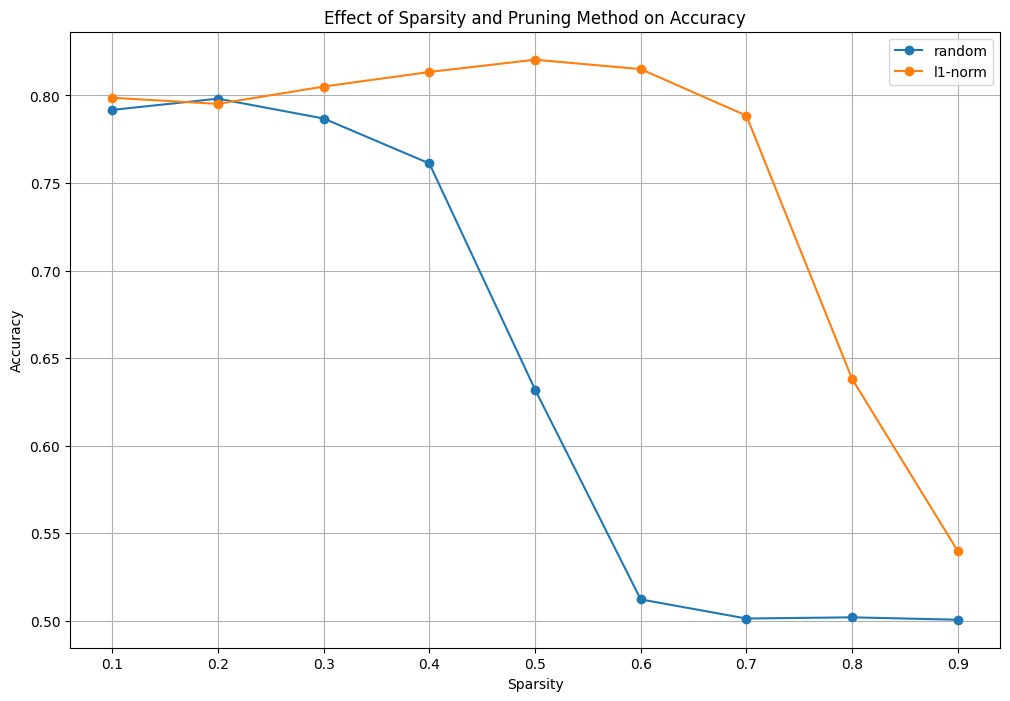

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(sparsity_values, accuracies[method], label=method, marker='o')

plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.title("Effect of Sparsity and Pruning Method on Accuracy")
plt.legend()
plt.grid(True)
plt.show()

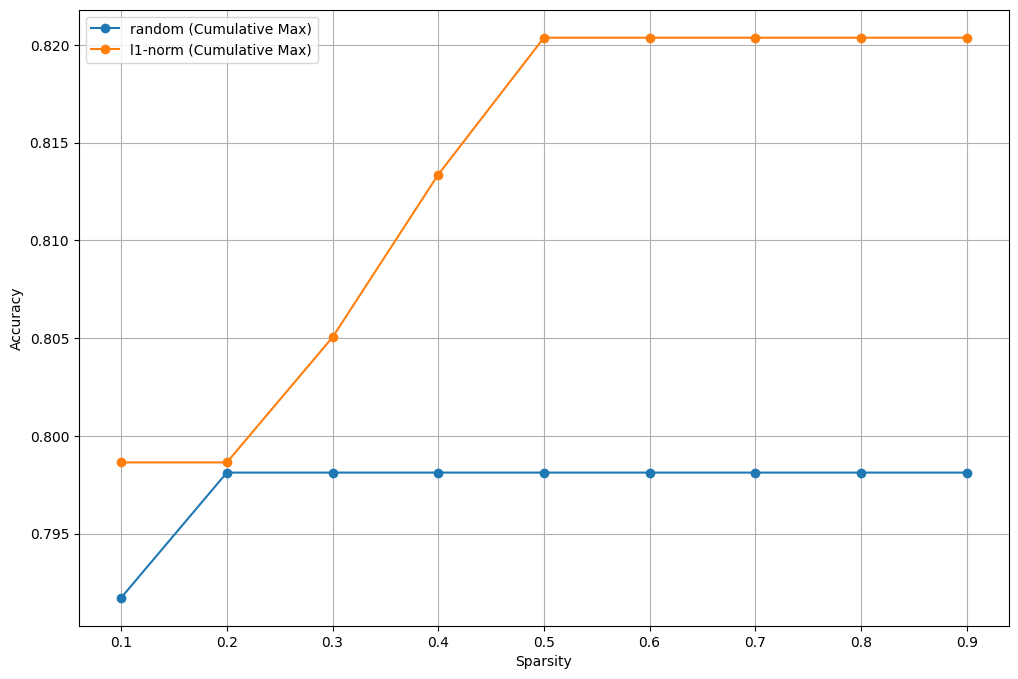

In [ ]:
import matplotlib.pyplot as plt



# Compute cumulative max accuracy for each method
cumulative_accuracies = {method: np.maximum.accumulate(accuracies[method]) for method in methods}

# Plot the cumulative max accuracy for the top two methods
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(sparsity_values, cumulative_accuracies[method], label=f"{method} (Cumulative Max)", marker='o')

plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.title(f"")
plt.legend()
plt.grid(True)
plt.show()
